## Accelerate Inference: Neural Network Pruning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/MLLD_pruning/dataset'

/content/drive/MyDrive/MLLD_pruning/dataset


In [3]:
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
!pwd

/content/drive/MyDrive/MLLD_pruning/dataset


In [6]:
# untar
# !ls
# !tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

In [7]:
train_images = torch.tensor(train_images, dtype=torch.float32)
val_images = torch.tensor(val_images, dtype=torch.float32)

train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)

In [8]:
train_dataset = TensorDataset(train_images,
                              torch.tensor(train_labels.squeeze(), dtype=torch.long))
val_dataset = TensorDataset(val_images,
                            torch.tensor(val_labels.squeeze(), dtype=torch.long))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [10]:
# @title
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.model = nn.Sequential(
            # First block: Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Second block: Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Flatten layer
            nn.Flatten(),

            # Fully connected block: Dense -> ReLU -> Dropout -> Dense -> Softmax
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
model = ConvNet()
criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(torch.load('my_model_weights_pretrained.pt'))

<All keys matched successfully>

In [12]:
device

device(type='cuda')

In [13]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for the validation loop
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():  # Disable gradient calculations for validation
        for inputs, labels in val_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update tqdm description with current validation loss and accuracy
            val_loader_tqdm.set_postfix(loss=val_loss / total, accuracy=100 * correct / total)

    val_accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)
    return val_loss, val_accuracy

# Experiments

In [33]:
# Experiment tracking setup
import json
from datetime import datetime
import copy

experiment_results = []
best_model_state = None
best_score = 0
best_config = None

def log_experiment(config, accuracy, sparsity, score):
    """Log experiment results"""
    result = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'config': config,
        'accuracy': accuracy,
        'sparsity': sparsity,
        'score': score
    }
    experiment_results.append(result)

    global best_model_state, best_score, best_config
    if score > best_score:
        best_score = score
        best_config = config
        best_model_state = copy.deepcopy(model.state_dict())

    # Print summary
    print(f"\n{'='*60}")
    print(f"Experiment: {config['name']}")
    print(f"Accuracy: {accuracy:.4f} | Sparsity: {sparsity:.4f} | Score: {score:.4f}")
    print(f"Best so far: {best_score:.4f}")
    print(f"{'='*60}\n")

    return result

def save_results():
    """Save all experiment results to JSON"""
    with open('experiment_results.json', 'w') as f:
        json.dump(experiment_results, f, indent=2)
    print(f"\n✅ Saved {len(experiment_results)} experiment results to experiment_results.json")

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()

    sparsity = zero_params / total_params
    return sparsity, zero_params, total_params

In [34]:
def train_one_epoch_with_mask(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Create masks before training - on the correct device
    masks = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            masks[name] = (param != 0).float().to(device)  # Add .to(device) here

    train_loader_tqdm = tqdm(train_loader, desc="Fine-tuning", leave=False)

    for inputs, labels in train_loader_tqdm:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply masks BEFORE optimizer step to keep zeros at zero
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in masks:
                    param.grad *= masks[name]

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=running_loss / total, accuracy=100 * correct / total)

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    return train_loss, train_accuracy

In [35]:
# iterative pruning
def iterative_pruning(model, train_loader, val_loader, criterion, device,
                     target_sparsity=0.7, num_iterations=3,
                     finetune_epochs=5, lr=0.0001):
    """
    Iteratively prune the model in steps

    Args:
        target_sparsity: Final desired sparsity level (e.g., 0.7 for 70%)
        num_iterations: Number of pruning iterations
        finetune_epochs: Epochs to finetune after each pruning step
        lr: Learning rate for finetuning
    """
    model = model.to(device)
    sparsity_per_iteration = target_sparsity / num_iterations

    print(f"Starting iterative pruning: {num_iterations} iterations to {target_sparsity*100}% sparsity")
    print(f"Pruning {sparsity_per_iteration*100:.2f}% per iteration\n")

    for iteration in range(num_iterations):
        print(f"\n{'='*60}")
        print(f"ITERATION {iteration+1}/{num_iterations}")
        print(f"{'='*60}")

        # Calculate current sparsity
        current_sparsity, _, _ = calculate_sparsity(model)
        target_iter_sparsity = (iteration + 1) * sparsity_per_iteration

        # Prune
        print(f"Current sparsity: {current_sparsity:.4f}, Target: {target_iter_sparsity:.4f}")
        with torch.no_grad():
            for name, param in model.named_parameters():
                if "weight" in name:
                    # Calculate how much more to prune
                    abs_weights = torch.abs(param)
                    threshold = torch.quantile(abs_weights[abs_weights != 0], sparsity_per_iteration)
                    param[abs_weights < threshold] = 0

        # Check sparsity after pruning
        new_sparsity, num_zeros, total_params = calculate_sparsity(model)
        print(f"After pruning: {new_sparsity:.4f} sparsity ({num_zeros}/{total_params} zeros)")

        # Finetune
        if finetune_epochs > 0:
            print(f"\nFinetuning for {finetune_epochs} epochs...")
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(finetune_epochs):
                train_loss, train_acc = train_one_epoch_with_mask(
                    model, train_loader, optimizer, criterion, device
                )
                val_loss, val_acc = validate(model, val_loader, criterion, device)
                print(f"  Epoch {epoch+1}/{finetune_epochs}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Evaluate
        final_loss, final_acc = validate(model, val_loader, criterion, device)
        final_sparsity, num_zeros, total_params = calculate_sparsity(model)

        if final_acc > 60 and final_sparsity > 0:
          score = ((final_acc / 100) + final_sparsity) / 2
        else:
            score = 0

        print(f"\nIteration {iteration+1} Results:")
        print(f"  Accuracy: {final_acc:.4f}")
        print(f"  Sparsity: {final_sparsity:.4f}")
        print(f"  Score: {score:.4f}")

    return model

In [36]:
print("EXPERIMENT 1: Testing different pruning thresholds with finetuning")
print("="*80)

thresholds_to_test = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8]

for threshold in thresholds_to_test:
    # Reload fresh model
    model = ConvNet()
    model.load_state_dict(torch.load('my_model_weights_pretrained.pt'))
    model = model.to(device)

    print(f"\n\nTesting threshold: {threshold} (target sparsity: {threshold*100}%)")
    print("-"*60)

    # Prune
    with torch.no_grad():
        for name, param in model.named_parameters():
            if "weight" in name:
                quantile_threshold = torch.quantile(torch.abs(param), threshold)
                param[torch.abs(param) < quantile_threshold] = 0

    # Check initial pruned accuracy
    init_loss, init_acc = validate(model, val_loader, criterion, device)
    init_sparsity, num_zeros, total_params = calculate_sparsity(model)
    print(f"After pruning - Acc: {init_acc:.4f}, Sparsity: {init_sparsity:.4f}")

    # Finetune
    print("Finetuning for 15 epochs...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    best_val_acc = 0
    for epoch in range(15):
        train_loss, train_acc = train_one_epoch_with_mask(
            model, train_loader, optimizer, criterion, device
        )
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/15: Val Acc: {val_acc:.2f}%")

    # Final evaluation
    final_loss, final_acc = validate(model, val_loader, criterion, device)
    final_sparsity, num_zeros, total_params = calculate_sparsity(model)

    if final_acc > 60 and final_sparsity > 0:
          score = ((final_acc / 100) + final_sparsity) / 2
    else:
        score = 0

    # Log results
    config = {
        'name': f'One-shot pruning + finetune (threshold={threshold})',
        'method': 'one-shot',
        'threshold': threshold,
        'finetune_epochs': 15,
        'learning_rate': 0.0001
    }

    log_experiment(config, final_acc, final_sparsity, score)

save_results()

EXPERIMENT 1: Testing different pruning thresholds with finetuning


Testing threshold: 0.5 (target sparsity: 50.0%)
------------------------------------------------------------


After pruning - Acc: 46.2970, Sparsity: 0.4994
Finetuning for 15 epochs...


  Epoch 5/15: Val Acc: 68.04%


  Epoch 10/15: Val Acc: 67.64%


  Epoch 15/15: Val Acc: 68.08%



Experiment: One-shot pruning + finetune (threshold=0.5)
Accuracy: 68.0792 | Sparsity: 0.4994 | Score: 0.5901
Best so far: 0.5901



Testing threshold: 0.6 (target sparsity: 60.0%)
------------------------------------------------------------


After pruning - Acc: 41.5446, Sparsity: 0.5993
Finetuning for 15 epochs...


  Epoch 5/15: Val Acc: 68.51%


  Epoch 10/15: Val Acc: 68.51%


  Epoch 15/15: Val Acc: 69.50%



Experiment: One-shot pruning + finetune (threshold=0.6)
Accuracy: 69.5050 | Sparsity: 0.5993 | Score: 0.6472
Best so far: 0.6472



Testing threshold: 0.65 (target sparsity: 65.0%)
------------------------------------------------------------


After pruning - Acc: 31.6832, Sparsity: 0.6492
Finetuning for 15 epochs...


  Epoch 5/15: Val Acc: 67.64%


  Epoch 10/15: Val Acc: 68.51%


  Epoch 15/15: Val Acc: 68.99%



Experiment: One-shot pruning + finetune (threshold=0.65)
Accuracy: 68.9901 | Sparsity: 0.6492 | Score: 0.6696
Best so far: 0.6696



Testing threshold: 0.7 (target sparsity: 70.0%)
------------------------------------------------------------


After pruning - Acc: 34.4950, Sparsity: 0.6992
Finetuning for 15 epochs...


  Epoch 5/15: Val Acc: 68.00%


  Epoch 10/15: Val Acc: 67.01%


  Epoch 15/15: Val Acc: 68.16%



Experiment: One-shot pruning + finetune (threshold=0.7)
Accuracy: 68.1584 | Sparsity: 0.6992 | Score: 0.6904
Best so far: 0.6904



Testing threshold: 0.75 (target sparsity: 75.0%)
------------------------------------------------------------


After pruning - Acc: 21.0297, Sparsity: 0.7491
Finetuning for 15 epochs...


  Epoch 5/15: Val Acc: 66.26%


  Epoch 10/15: Val Acc: 67.13%


  Epoch 15/15: Val Acc: 67.25%



Experiment: One-shot pruning + finetune (threshold=0.75)
Accuracy: 67.2475 | Sparsity: 0.7491 | Score: 0.7108
Best so far: 0.7108



Testing threshold: 0.8 (target sparsity: 80.0%)
------------------------------------------------------------


After pruning - Acc: 20.8713, Sparsity: 0.7990
Finetuning for 15 epochs...


  Epoch 5/15: Val Acc: 64.40%


  Epoch 10/15: Val Acc: 65.74%


  Epoch 15/15: Val Acc: 67.21%



Experiment: One-shot pruning + finetune (threshold=0.8)
Accuracy: 67.2079 | Sparsity: 0.7990 | Score: 0.7356
Best so far: 0.7356


✅ Saved 6 experiment results to experiment_results.json


In [37]:
print("\n\nEXPERIMENT 2: Testing iterative pruning strategies")
print("="*80)

iterative_configs = [
    {'target_sparsity': 0.7, 'num_iterations': 2, 'finetune_epochs': 7, 'lr': 0.0001},
    {'target_sparsity': 0.7, 'num_iterations': 3, 'finetune_epochs': 5, 'lr': 0.0001},
    {'target_sparsity': 0.7, 'num_iterations': 5, 'finetune_epochs': 3, 'lr': 0.0001},
    {'target_sparsity': 0.65, 'num_iterations': 3, 'finetune_epochs': 5, 'lr': 0.0001},
    {'target_sparsity': 0.75, 'num_iterations': 3, 'finetune_epochs': 5, 'lr': 0.00005},
]

for config_params in iterative_configs:
    print(f"\n\nTesting config: {config_params}")
    print("-"*60)

    # Reload fresh model
    model = ConvNet()
    model.load_state_dict(torch.load('my_model_weights_pretrained.pt'))

    # Run iterative pruning
    model = iterative_pruning(
        model, train_loader, val_loader, criterion, device,
        target_sparsity=config_params['target_sparsity'],
        num_iterations=config_params['num_iterations'],
        finetune_epochs=config_params['finetune_epochs'],
        lr=config_params['lr']
    )

    # Final evaluation
    final_loss, final_acc = validate(model, val_loader, criterion, device)
    final_sparsity, num_zeros, total_params = calculate_sparsity(model)

    if final_acc > 60 and final_sparsity > 0:
          score = ((final_acc / 100) + final_sparsity) / 2
    else:
        score = 0

    # Log results
    config = {
        'name': f'Iterative pruning ({config_params["num_iterations"]} iterations)',
        'method': 'iterative',
        **config_params
    }

    log_experiment(config, final_acc, final_sparsity, score)

save_results()



EXPERIMENT 2: Testing iterative pruning strategies


Testing config: {'target_sparsity': 0.7, 'num_iterations': 2, 'finetune_epochs': 7, 'lr': 0.0001}
------------------------------------------------------------
Starting iterative pruning: 2 iterations to 70.0% sparsity
Pruning 35.00% per iteration


ITERATION 1/2
Current sparsity: 0.0000, Target: 0.3500
After pruning: 0.3496 sparsity (207280/592933 zeros)

Finetuning for 7 epochs...


  Epoch 1/7: Train Acc: 73.10%, Val Acc: 67.96%


  Epoch 2/7: Train Acc: 73.49%, Val Acc: 66.73%


  Epoch 3/7: Train Acc: 73.59%, Val Acc: 67.92%


  Epoch 4/7: Train Acc: 73.88%, Val Acc: 68.48%


  Epoch 5/7: Train Acc: 74.42%, Val Acc: 68.28%


  Epoch 6/7: Train Acc: 74.54%, Val Acc: 69.03%


  Epoch 7/7: Train Acc: 74.64%, Val Acc: 68.71%



Iteration 1 Results:
  Accuracy: 68.7129
  Sparsity: 0.3496
  Score: 0.5184

ITERATION 2/2
Current sparsity: 0.3496, Target: 0.7000
After pruning: 0.5768 sparsity (342011/592933 zeros)

Finetuning for 7 epochs...


  Epoch 1/7: Train Acc: 71.08%, Val Acc: 68.20%


  Epoch 2/7: Train Acc: 73.36%, Val Acc: 69.11%


  Epoch 3/7: Train Acc: 73.61%, Val Acc: 68.83%


  Epoch 4/7: Train Acc: 74.71%, Val Acc: 69.15%


  Epoch 5/7: Train Acc: 74.71%, Val Acc: 69.11%


  Epoch 6/7: Train Acc: 75.35%, Val Acc: 68.95%


  Epoch 7/7: Train Acc: 75.63%, Val Acc: 69.43%



Iteration 2 Results:
  Accuracy: 69.4257
  Sparsity: 0.5768
  Score: 0.6355



Experiment: Iterative pruning (2 iterations)
Accuracy: 69.4257 | Sparsity: 0.5768 | Score: 0.6355
Best so far: 0.7356



Testing config: {'target_sparsity': 0.7, 'num_iterations': 3, 'finetune_epochs': 5, 'lr': 0.0001}
------------------------------------------------------------
Starting iterative pruning: 3 iterations to 70.0% sparsity
Pruning 23.33% per iteration


ITERATION 1/3
Current sparsity: 0.0000, Target: 0.2333
After pruning: 0.2331 sparsity (138188/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 73.46%, Val Acc: 67.88%


  Epoch 2/5: Train Acc: 73.26%, Val Acc: 67.13%


  Epoch 3/5: Train Acc: 74.11%, Val Acc: 68.20%


  Epoch 4/5: Train Acc: 73.95%, Val Acc: 66.93%


  Epoch 5/5: Train Acc: 74.39%, Val Acc: 68.48%



Iteration 1 Results:
  Accuracy: 68.4752
  Sparsity: 0.2331
  Score: 0.4589

ITERATION 2/3
Current sparsity: 0.2331, Target: 0.4667
After pruning: 0.4117 sparsity (244132/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 73.70%, Val Acc: 68.71%


  Epoch 2/5: Train Acc: 74.65%, Val Acc: 68.32%


  Epoch 3/5: Train Acc: 75.14%, Val Acc: 69.19%


  Epoch 4/5: Train Acc: 75.30%, Val Acc: 68.99%


  Epoch 5/5: Train Acc: 75.62%, Val Acc: 68.99%



Iteration 2 Results:
  Accuracy: 68.9901
  Sparsity: 0.4117
  Score: 0.5508

ITERATION 3/3
Current sparsity: 0.4117, Target: 0.7000
After pruning: 0.5487 sparsity (325355/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 72.35%, Val Acc: 68.83%


  Epoch 2/5: Train Acc: 74.91%, Val Acc: 69.15%


  Epoch 3/5: Train Acc: 75.31%, Val Acc: 68.67%


  Epoch 4/5: Train Acc: 75.88%, Val Acc: 69.74%


  Epoch 5/5: Train Acc: 75.80%, Val Acc: 69.54%



Iteration 3 Results:
  Accuracy: 69.5446
  Sparsity: 0.5487
  Score: 0.6221



Experiment: Iterative pruning (3 iterations)
Accuracy: 69.5446 | Sparsity: 0.5487 | Score: 0.6221
Best so far: 0.7356



Testing config: {'target_sparsity': 0.7, 'num_iterations': 5, 'finetune_epochs': 3, 'lr': 0.0001}
------------------------------------------------------------
Starting iterative pruning: 5 iterations to 70.0% sparsity
Pruning 14.00% per iteration


ITERATION 1/5
Current sparsity: 0.0000, Target: 0.1400
After pruning: 0.1398 sparsity (82914/592933 zeros)

Finetuning for 3 epochs...


  Epoch 1/3: Train Acc: 72.82%, Val Acc: 67.92%


  Epoch 2/3: Train Acc: 73.58%, Val Acc: 66.38%


  Epoch 3/3: Train Acc: 73.97%, Val Acc: 67.88%



Iteration 1 Results:
  Accuracy: 67.8812
  Sparsity: 0.1398
  Score: 0.4093

ITERATION 2/5
Current sparsity: 0.1398, Target: 0.2800
After pruning: 0.2601 sparsity (154219/592933 zeros)

Finetuning for 3 epochs...


  Epoch 1/3: Train Acc: 73.76%, Val Acc: 67.88%


  Epoch 2/3: Train Acc: 74.64%, Val Acc: 68.51%


  Epoch 3/3: Train Acc: 75.25%, Val Acc: 67.96%



Iteration 2 Results:
  Accuracy: 67.9604
  Sparsity: 0.2601
  Score: 0.4698

ITERATION 3/5
Current sparsity: 0.2601, Target: 0.4200
After pruning: 0.3635 sparsity (215541/592933 zeros)

Finetuning for 3 epochs...


  Epoch 1/3: Train Acc: 74.55%, Val Acc: 68.12%


  Epoch 2/3: Train Acc: 74.95%, Val Acc: 68.32%


  Epoch 3/3: Train Acc: 75.61%, Val Acc: 69.19%



Iteration 3 Results:
  Accuracy: 69.1881
  Sparsity: 0.3635
  Score: 0.5277

ITERATION 4/5
Current sparsity: 0.3635, Target: 0.5600
After pruning: 0.4525 sparsity (268279/592933 zeros)

Finetuning for 3 epochs...


  Epoch 1/3: Train Acc: 74.82%, Val Acc: 68.51%


  Epoch 2/3: Train Acc: 75.94%, Val Acc: 69.62%


  Epoch 3/3: Train Acc: 76.03%, Val Acc: 69.43%



Iteration 4 Results:
  Accuracy: 69.4257
  Sparsity: 0.4525
  Score: 0.5734

ITERATION 5/5
Current sparsity: 0.4525, Target: 0.7000
After pruning: 0.5290 sparsity (313633/592933 zeros)

Finetuning for 3 epochs...


  Epoch 1/3: Train Acc: 74.96%, Val Acc: 69.50%


  Epoch 2/3: Train Acc: 76.16%, Val Acc: 70.22%


  Epoch 3/3: Train Acc: 76.24%, Val Acc: 69.50%



Iteration 5 Results:
  Accuracy: 69.5050
  Sparsity: 0.5290
  Score: 0.6120



Experiment: Iterative pruning (5 iterations)
Accuracy: 69.5050 | Sparsity: 0.5290 | Score: 0.6120
Best so far: 0.7356



Testing config: {'target_sparsity': 0.65, 'num_iterations': 3, 'finetune_epochs': 5, 'lr': 0.0001}
------------------------------------------------------------
Starting iterative pruning: 3 iterations to 65.0% sparsity
Pruning 21.67% per iteration


ITERATION 1/3
Current sparsity: 0.0000, Target: 0.2167
After pruning: 0.2164 sparsity (128316/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 72.81%, Val Acc: 67.76%


  Epoch 2/5: Train Acc: 73.53%, Val Acc: 68.32%


  Epoch 3/5: Train Acc: 73.74%, Val Acc: 67.84%


  Epoch 4/5: Train Acc: 74.45%, Val Acc: 67.72%


  Epoch 5/5: Train Acc: 74.61%, Val Acc: 67.84%



Iteration 1 Results:
  Accuracy: 67.8416
  Sparsity: 0.2164
  Score: 0.4474

ITERATION 2/3
Current sparsity: 0.2164, Target: 0.4333
After pruning: 0.3859 sparsity (228832/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 73.59%, Val Acc: 68.00%


  Epoch 2/5: Train Acc: 74.73%, Val Acc: 68.51%


  Epoch 3/5: Train Acc: 74.91%, Val Acc: 69.19%


  Epoch 4/5: Train Acc: 75.35%, Val Acc: 69.03%


  Epoch 5/5: Train Acc: 76.02%, Val Acc: 69.47%



Iteration 2 Results:
  Accuracy: 69.4653
  Sparsity: 0.3859
  Score: 0.5403

ITERATION 3/3
Current sparsity: 0.3859, Target: 0.6500
After pruning: 0.5187 sparsity (307569/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 73.19%, Val Acc: 68.67%


  Epoch 2/5: Train Acc: 75.45%, Val Acc: 69.86%


  Epoch 3/5: Train Acc: 76.01%, Val Acc: 69.47%


  Epoch 4/5: Train Acc: 75.92%, Val Acc: 68.95%


  Epoch 5/5: Train Acc: 76.61%, Val Acc: 69.27%



Iteration 3 Results:
  Accuracy: 69.2673
  Sparsity: 0.5187
  Score: 0.6057



Experiment: Iterative pruning (3 iterations)
Accuracy: 69.2673 | Sparsity: 0.5187 | Score: 0.6057
Best so far: 0.7356



Testing config: {'target_sparsity': 0.75, 'num_iterations': 3, 'finetune_epochs': 5, 'lr': 5e-05}
------------------------------------------------------------
Starting iterative pruning: 3 iterations to 75.0% sparsity
Pruning 25.00% per iteration


ITERATION 1/3
Current sparsity: 0.0000, Target: 0.2500
After pruning: 0.2497 sparsity (148056/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 73.58%, Val Acc: 68.12%


  Epoch 2/5: Train Acc: 73.75%, Val Acc: 68.04%


  Epoch 3/5: Train Acc: 74.31%, Val Acc: 68.48%


  Epoch 4/5: Train Acc: 74.71%, Val Acc: 68.44%


  Epoch 5/5: Train Acc: 74.67%, Val Acc: 68.12%



Iteration 1 Results:
  Accuracy: 68.1188
  Sparsity: 0.2497
  Score: 0.4654

ITERATION 2/3
Current sparsity: 0.2497, Target: 0.5000
After pruning: 0.4370 sparsity (259098/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 73.18%, Val Acc: 67.37%


  Epoch 2/5: Train Acc: 74.15%, Val Acc: 67.84%


  Epoch 3/5: Train Acc: 74.45%, Val Acc: 68.16%


  Epoch 4/5: Train Acc: 74.34%, Val Acc: 68.75%


  Epoch 5/5: Train Acc: 75.19%, Val Acc: 68.48%



Iteration 2 Results:
  Accuracy: 68.4752
  Sparsity: 0.4370
  Score: 0.5609

ITERATION 3/3
Current sparsity: 0.4370, Target: 0.7500
After pruning: 0.5774 sparsity (342380/592933 zeros)

Finetuning for 5 epochs...


  Epoch 1/5: Train Acc: 70.51%, Val Acc: 67.64%


  Epoch 2/5: Train Acc: 73.45%, Val Acc: 67.68%


  Epoch 3/5: Train Acc: 73.44%, Val Acc: 68.28%


  Epoch 4/5: Train Acc: 74.15%, Val Acc: 68.83%


  Epoch 5/5: Train Acc: 74.12%, Val Acc: 68.95%



Iteration 3 Results:
  Accuracy: 68.9505
  Sparsity: 0.5774
  Score: 0.6335



Experiment: Iterative pruning (3 iterations)
Accuracy: 68.9505 | Sparsity: 0.5774 | Score: 0.6335
Best so far: 0.7356


✅ Saved 11 experiment results to experiment_results.json


In [38]:
print("\n\nEXPERIMENT 3: Testing different learning rates for finetuning")
print("="*80)

learning_rates = [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
target_threshold = 0.7  # Use best threshold from previous experiments

for lr in learning_rates:
    print(f"\n\nTesting learning rate: {lr}")
    print("-"*60)

    # Reload fresh model
    model = ConvNet()
    model.load_state_dict(torch.load('my_model_weights_pretrained.pt'))
    model = model.to(device)

    # Prune with fixed threshold
    with torch.no_grad():
        for name, param in model.named_parameters():
            if "weight" in name:
                quantile_threshold = torch.quantile(torch.abs(param), target_threshold)
                param[torch.abs(param) < quantile_threshold] = 0

    init_loss, init_acc = validate(model, val_loader, criterion, device)
    print(f"After pruning - Acc: {init_acc:.4f}")

    # Finetune with specific learning rate
    print(f"Finetuning with lr={lr}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(15):
        train_loss, train_acc = train_one_epoch_with_mask(
            model, train_loader, optimizer, criterion, device
        )
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/15: Val Acc: {val_acc:.2f}%")

    # Final evaluation
    final_loss, final_acc = validate(model, val_loader, criterion, device)
    final_sparsity, num_zeros, total_params = calculate_sparsity(model)

    if final_acc > 60 and final_sparsity > 0:
          score = ((final_acc / 100) + final_sparsity) / 2
    else:
        score = 0

    # Log results
    config = {
        'name': f'Finetune with lr={lr}',
        'method': 'one-shot',
        'threshold': target_threshold,
        'finetune_epochs': 15,
        'learning_rate': lr
    }

    log_experiment(config, final_acc, final_sparsity, score)

save_results()



EXPERIMENT 3: Testing different learning rates for finetuning


Testing learning rate: 1e-05
------------------------------------------------------------


After pruning - Acc: 34.4950
Finetuning with lr=1e-05...


  Epoch 5/15: Val Acc: 64.91%


  Epoch 10/15: Val Acc: 65.82%


  Epoch 15/15: Val Acc: 65.90%



Experiment: Finetune with lr=1e-05
Accuracy: 65.9010 | Sparsity: 0.6992 | Score: 0.6791
Best so far: 0.7356



Testing learning rate: 5e-05
------------------------------------------------------------


After pruning - Acc: 34.4950
Finetuning with lr=5e-05...


  Epoch 5/15: Val Acc: 67.05%


  Epoch 10/15: Val Acc: 67.33%


  Epoch 15/15: Val Acc: 67.52%



Experiment: Finetune with lr=5e-05
Accuracy: 67.5248 | Sparsity: 0.6992 | Score: 0.6872
Best so far: 0.7356



Testing learning rate: 0.0001
------------------------------------------------------------


After pruning - Acc: 34.4950
Finetuning with lr=0.0001...


  Epoch 5/15: Val Acc: 67.49%


  Epoch 10/15: Val Acc: 68.08%


  Epoch 15/15: Val Acc: 68.67%



Experiment: Finetune with lr=0.0001
Accuracy: 68.6733 | Sparsity: 0.6992 | Score: 0.6929
Best so far: 0.7356



Testing learning rate: 0.0005
------------------------------------------------------------


After pruning - Acc: 34.4950
Finetuning with lr=0.0005...


  Epoch 5/15: Val Acc: 68.87%


  Epoch 10/15: Val Acc: 67.56%


  Epoch 15/15: Val Acc: 68.04%



Experiment: Finetune with lr=0.0005
Accuracy: 68.0396 | Sparsity: 0.6992 | Score: 0.6898
Best so far: 0.7356



Testing learning rate: 0.001
------------------------------------------------------------


After pruning - Acc: 34.4950
Finetuning with lr=0.001...


  Epoch 5/15: Val Acc: 68.40%


  Epoch 10/15: Val Acc: 69.23%


  Epoch 15/15: Val Acc: 70.30%



Experiment: Finetune with lr=0.001
Accuracy: 70.2970 | Sparsity: 0.6992 | Score: 0.7011
Best so far: 0.7356


✅ Saved 16 experiment results to experiment_results.json


In [39]:
print("\n\n" + "="*80)
print("EXPERIMENT SUMMARY")
print("="*80)

# Sort by score
sorted_results = sorted(experiment_results, key=lambda x: x['score'], reverse=True)

print(f"\nTop 5 Configurations:")
print("-"*80)
for i, result in enumerate(sorted_results[:5], 1):
    print(f"\n{i}. {result['config']['name']}")
    print(f"   Accuracy: {result['accuracy']:.4f} | Sparsity: {result['sparsity']:.4f} | Score: {result['score']:.4f}")
    print(f"   Config: {result['config']}")

print(f"\n\n{'='*80}")
print(f"BEST OVERALL RESULT:")
print(f"{'='*80}")
print(f"Configuration: {best_config['name']}")
print(f"Score: {best_score:.4f}")
print(f"Full config: {best_config}")

# Save best model
if best_model_state is not None:
    torch.save(best_model_state, 'my_model_weights_1_best.pt', _use_new_zipfile_serialization=False)
    print(f"\n✅ Best model saved to: my_model_weights_1_best.pt")

# Save detailed results
save_results()

# Create visualization data
accuracies = [r['accuracy'] for r in experiment_results]
sparsities = [r['sparsity'] for r in experiment_results]
scores = [r['score'] for r in experiment_results]

print(f"\n\nStatistics across {len(experiment_results)} experiments:")
print(f"  Accuracy: min={min(accuracies):.4f}, max={max(accuracies):.4f}, avg={sum(accuracies)/len(accuracies):.4f}")
print(f"  Sparsity: min={min(sparsities):.4f}, max={max(sparsities):.4f}, avg={sum(sparsities)/len(sparsities):.4f}")
print(f"  Score: min={min(scores):.4f}, max={max(scores):.4f}, avg={sum(scores)/len(scores):.4f}")



EXPERIMENT SUMMARY

Top 5 Configurations:
--------------------------------------------------------------------------------

1. One-shot pruning + finetune (threshold=0.8)
   Accuracy: 67.2079 | Sparsity: 0.7990 | Score: 0.7356
   Config: {'name': 'One-shot pruning + finetune (threshold=0.8)', 'method': 'one-shot', 'threshold': 0.8, 'finetune_epochs': 15, 'learning_rate': 0.0001}

2. One-shot pruning + finetune (threshold=0.75)
   Accuracy: 67.2475 | Sparsity: 0.7491 | Score: 0.7108
   Config: {'name': 'One-shot pruning + finetune (threshold=0.75)', 'method': 'one-shot', 'threshold': 0.75, 'finetune_epochs': 15, 'learning_rate': 0.0001}

3. Finetune with lr=0.001
   Accuracy: 70.2970 | Sparsity: 0.6992 | Score: 0.7011
   Config: {'name': 'Finetune with lr=0.001', 'method': 'one-shot', 'threshold': 0.7, 'finetune_epochs': 15, 'learning_rate': 0.001}

4. Finetune with lr=0.0001
   Accuracy: 68.6733 | Sparsity: 0.6992 | Score: 0.6929
   Config: {'name': 'Finetune with lr=0.0001', 'method

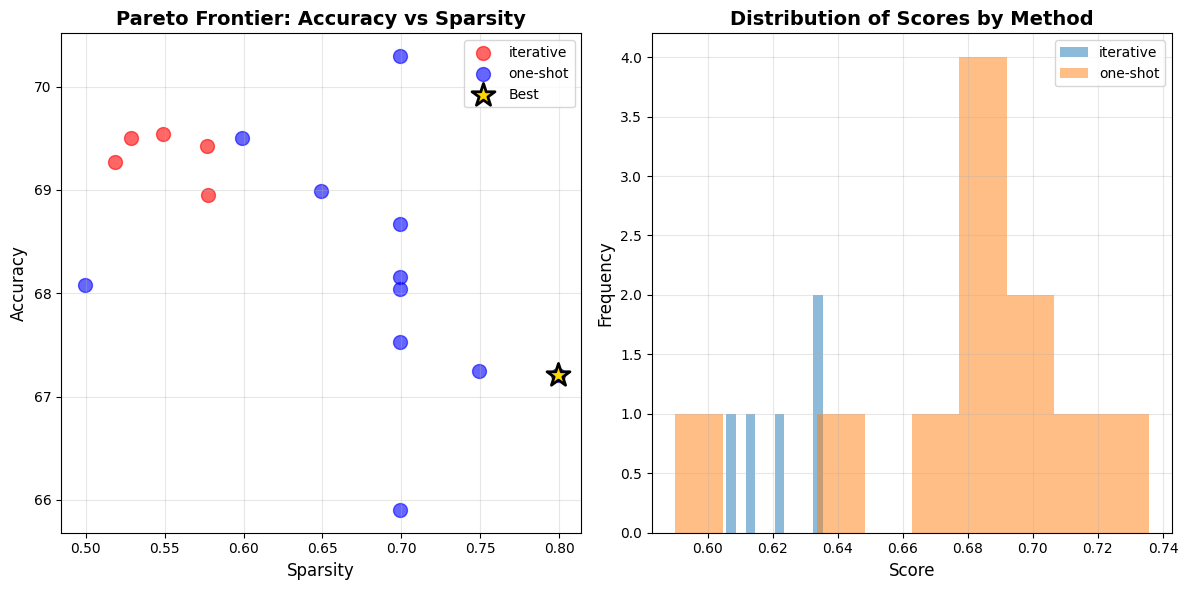

✅ Visualization saved to: experiment_results_visualization.png


In [40]:
import matplotlib.pyplot as plt

# Extract data for plotting
accuracies = [r['accuracy'] for r in experiment_results]
sparsities = [r['sparsity'] for r in experiment_results]
scores = [r['score'] for r in experiment_results]
methods = [r['config']['method'] for r in experiment_results]

# Create scatter plot
plt.figure(figsize=(12, 6))

# Plot 1: Accuracy vs Sparsity
plt.subplot(1, 2, 1)
colors = {'one-shot': 'blue', 'iterative': 'red'}
for method in set(methods):
    mask = [m == method for m in methods]
    plt.scatter(
        [s for s, m in zip(sparsities, mask) if m],
        [a for a, m in zip(accuracies, mask) if m],
        label=method, alpha=0.6, s=100, c=colors.get(method, 'gray')
    )

# Highlight best result
best_idx = scores.index(max(scores))
plt.scatter(sparsities[best_idx], accuracies[best_idx],
           color='gold', s=300, marker='*', edgecolors='black',
           linewidths=2, label='Best', zorder=5)

plt.xlabel('Sparsity', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Pareto Frontier: Accuracy vs Sparsity', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Overall Score Distribution
plt.subplot(1, 2, 2)
for method in set(methods):
    mask = [m == method for m in methods]
    method_scores = [s for s, m in zip(scores, mask) if m]
    plt.hist(method_scores, alpha=0.5, label=method, bins=10)

plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Scores by Method', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to: experiment_results_visualization.png")

In [41]:
# Cell 8: Load and test the best model
print("\n" + "="*80)
print("LOADING AND TESTING BEST MODEL")
print("="*80)

# Load best model
best_model = ConvNet()
best_model.load_state_dict(torch.load('my_model_weights_1_best.pt'))
best_model = best_model.to(device)

# Evaluate
final_loss, final_acc = validate(best_model, val_loader, criterion, device)
final_sparsity, num_zeros, total_params = calculate_sparsity(best_model)

if final_acc > 60 and final_sparsity > 0:
          score = ((final_acc / 100) + final_sparsity) / 2
else:
    score = 0

print(f"\nBest Model Performance:")
print(f"  Accuracy: {final_acc:.4f}")
print(f"  Sparsity: {final_sparsity:.4f} ({num_zeros}/{total_params} zeros)")
print(f"  Score: {score:.4f}")
print(f"\nConfiguration used: {best_config['name']}")


LOADING AND TESTING BEST MODEL



Best Model Performance:
  Accuracy: 67.2079
  Sparsity: 0.7990 (473777/592933 zeros)
  Score: 0.7356

Configuration used: One-shot pruning + finetune (threshold=0.8)
